# RBC Calibration Exercise

I begin with log-linearized equilibrium conditions from a simple RBC model with a labor-leisure tradeoff and Cobb-Douglas production.

I pick calibration values for economic parameters based on data/literature.

I estimate $\lambda$ variables to express the model as a state-space model.

Finally, I plot impulse response functions and describe cross-correlations

In [1]:
using Optim
using Plots

## (0) Equilibrium Conditions

#### Euler Equation

$E_t [\tilde{R_{t+1}}-\tilde{c_{t+1}}]+\tilde{c}=0$

#### Interest Rate

$(1+R^*)^{-1}\alpha\frac{y^*}{k^*}[\tilde{y_t}-\tilde{k_t}]-\tilde{R_t}=0$

#### Labor/Leisure Condition

$\tilde{y_t} - \tilde{c_t} - \frac{1}{1-l^*} \tilde{l_t}=0$

#### Production

$\tilde{y} - \tilde{A} - \alpha \tilde{k} - (1-\alpha)\tilde{l}=0$

#### Resource Constraint

$y^*\tilde{y} -c^*\tilde{c} -k^*(1+\gamma)\tilde{k_{t+1}}+k^*(1-\delta)\tilde{k} = 0$


#### Law of Motion of Productivity

$E_t[\tilde{A_{t+1}}] - \rho_A \tilde{A_t}=0$

## (1) Calibration

In [176]:

#gamma = 0.016; # Yearly
gamma = 0.004; # Monthly
R_k = 0.065;

beta = (1 + gamma) / (1 + R_k); # 0.9375;
#beta = .9375; # Yearly
beta = 0.984; # Monthly

alpha = 0.33;

#delta = 0.10; # Yearly
delta = 0.025; # Monthly

ky_star = (((1+gamma)/beta + delta - 1)/alpha)^-1;
iy_star = (gamma + delta) * ky_star;
cy_star = 1-iy_star;

lstar = 0.2;
b = (1+(lstar/(1-lstar)) * (1-alpha)^-1 * cy_star)^-1;

rhoA = 0.979;
sigmaA = 0.0072;

rstar = -delta + alpha * ky_star^-1;

0.020325203252032374

In [3]:
# State Variables:

# capital (k)
# productivity (a)

# Policy functions:

# 1. consumption (c)
# 2. labor (l)
# 3. capital next period (k)
# 4. interest rate (r)
# 5. income (y)
# 6. expected productivity (a)
# 7. capital this period (p)
# 8. productivity this period (q)

### Write Objective

Choose lambda_xk and lambda_xy
to minimize LHS of equilibrium conditions

(set constraint for lambda_kk to be less than or equal to 1)

In [211]:
# Define Each Equilibrium Condition
# as a value to minimize

# value of Lambda for Euler Equation for stateVar
# e.g. \Lambda_{ee,k}

function EulerEquationLoss(lambda, stateVar)
    loss = lambda["c$stateVar"]
    + lambda["rk"] * lambda["k$stateVar"]
    + lambda["ra"] * lambda["a$stateVar"]
    - lambda["ck"] * lambda["k$stateVar"]
    - lambda["ca"] * lambda["a$stateVar"];
    return loss
end

function InterestRateLoss(lambda, stateVar)
    q = alpha * (ky_star)^-1;
    loss = q * (lambda["y$stateVar"] 
    - Float64(stateVar == "k"))
    - (1+rstar) * lambda["r$stateVar"];
    return loss
end

function LaborLeisureLoss(lambda, stateVar)
    q = (1 - lstar)^-1;
    loss = lambda["y$stateVar"] - lambda["c$stateVar"] 
         - q * lambda["l$stateVar"];
    return loss
end

function ProductionLoss(lambda, stateVar)
    loss = lambda["y$stateVar"]
    - Float64(stateVar == "a")
    - alpha * Float64(stateVar == "k")
    - (1-alpha) * lambda["l$stateVar"];
    return loss
end

function ResourceLoss(lambda, stateVar)
    loss = lambda["y$stateVar"] 
    - cy_star * lambda["c$stateVar"]
    - ky_star * (1 + gamma) * lambda["k$stateVar"]
    + ky_star * (1 - delta) * Float64(stateVar == "k");
    return loss
end

function LawOfMotionProdLoss(lambda, stateVar)
    loss = lambda["a$stateVar"] - rhoA * Float64(stateVar == "a");
    return loss
end

LawOfMotionProdLoss (generic function with 1 method)

In [212]:
stateVars = ["k","a"];
eqmConds = [EulerEquationLoss, InterestRateLoss, 
    LaborLeisureLoss, ProductionLoss, ResourceLoss,
    LawOfMotionProdLoss];

# Sum of values of all eqm conditions
# 6 conds x 2 statevars = 12 conditions
function objLambda(lambda)
    
    # Add sum of squared differences of each
    # eqm condition
    value = sum([eqmCond(lambda, stateVar)
        for stateVar in stateVars,
        eqmCond in eqmConds] .^ 2);
    
    # Add a penalty to keep kk < 1
    value += 100 * (lambda["kk"] > 1);
    return value
end

function toLambda(x)
    lambda = Dict{AbstractString, Float64}();
    
    policies = ["c","l","y","r","k","a"];
    nPolicies = size(policies,1);
    states = ["k","a"];
    
    for (i, state) in enumerate(states)
        for (j, policy) in enumerate(policies)
            lambda["$policy$state"] = x[nPolicies * (i-1) + j];
        end
    end
    
    return lambda
end

# Convert x coordinates into
# lambda dictionary
# all _k's first, then all _l's 
# c, l, y, r, k, a
# lambda is in R^12
function obj(x)
    return objLambda(toLambda(x))
end

obj (generic function with 1 method)

In [ ]:
using Distributions

INFO: Recompiling stale cache file /Users/royang/.julia/lib/v0.4/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /Users/royang/.julia/lib/v0.4/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /Users/royang/.julia/lib/v0.4/Rmath.ji for module Rmath.
INFO: Recompiling stale cache file /Users/royang/.julia/lib/v0.4/StatsFuns.ji for module StatsFuns.
INFO: Recompiling stale cache file /Users/royang/.julia/lib/v0.4/StatsBase.ji for module StatsBase.


In [213]:
# Optimize

x0 = ones(12) * 0.01;
res = optimize(obj, x0, BFGS())

print(res)
print("----------------\n")
lambda = toLambda(res.minimum);
eqmCondValues = [(stateVar, eqmCond, eqmCond(lambda, stateVar))
        for stateVar in stateVars,
        eqmCond in eqmConds];

# Print Eqm Condition Values
for e in eqmCondValues
    if abs(e[3]) > 0.01
        print("\t")
    end
    print(e)
    print("\n")
end
print("----------------\n")
# Print Lambda Values
lambda

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.01,0.01, ...]
 * Minimizer: [0.00041053745094337107,0.01, ...]
 * Minimum: 2.052687e-03
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 11
 * Gradient Calls: 11----------------
("k",EulerEquationLoss,0.00041053745094337107)
("a",EulerEquationLoss,-3.019199473763834e-14)
	("k",InterestRateLoss,-0.045287987865219446)
("a",InterestRateLoss,-2.346888879880216e-15)
("k",LaborLeisureLoss,0.00041053745093827293)
("a",LaborLeisureLoss,-2.1586898935055387e-14)
("k",ProductionLoss,0.000821074901881644)
("a",ProductionLoss,-5.1778893672693727e-14)
("k",ResourceLoss,0.000821074901881644)
("a",ResourceLoss,-5.1778893672693727e-14)
("k",LawOfMotionProdLoss,1.8063421720748024e-13)
("a",LawOfMotionProdLoss,2.989275493803234e-12)
----------------


Dict{AbstractString,Float64} with 12 entries:
  "ka" => 0.01
  "ra" => 0.01
  "ca" => -3.019199473763834e-14
  "aa" => 0.9790000000029893
  "rk" => 0.01
  "ck" => 0.00041053745094337107
  "ya" => -5.1778893672693727e-14
  "yk" => 0.000821074901881644
  "la" => 0.01
  "ak" => 1.8063421720748024e-13
  "lk" => 0.01
  "kk" => 0.01

In [214]:
# Extract State Transition Matrix
lambda = toLambda(res.minimum)
T = [[lambda["kk"] lambda["ka"]], 
    [lambda["ak"] lambda["aa"]]];

# Extract fns for policy variables
C = [lambda["ck"] lambda["ca"]];
L = [lambda["lk"] lambda["la"]];
Y = [lambda["yk"] lambda["ya"]];
R = [lambda["rk"] lambda["ra"]];

P = [C,L,Y,R];

# Set Initial State
s0 = [0.00 , 0.01];
P
T

2x2 Array{Float64,2}:
 0.01         0.01 
 1.80634e-13  0.979

In [215]:
pds = 100;

# Define States by Applying Transition Matrix
s = Array{Float64}(2,pds);

# Define Policy Variables
policy = Array{Float64}(4,pds);

s[:,1] = s0;
policy[:,1] = P * s0;
for p in 2:pds
    s[:,p] = T * s[:,p-1];
    policy[:,p] = P * s[:,p];
end




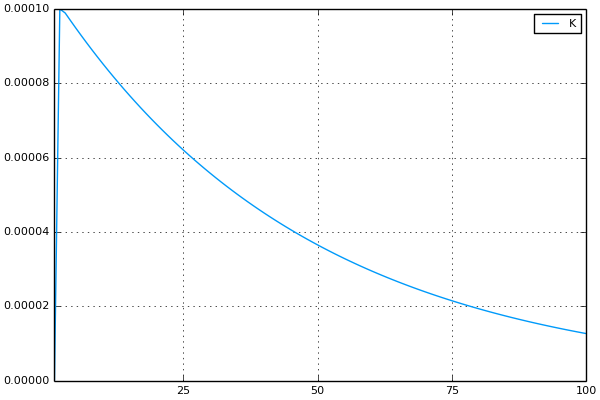

In [216]:
plot(1:pds, s[1,:]', label="K")
#plot!(1:pds, s[2,:]', label="A")


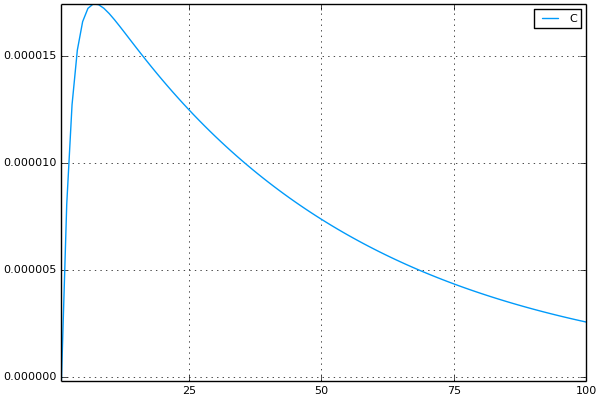

In [190]:
# C
plot(1:pds, policy[1,:]', label="C")


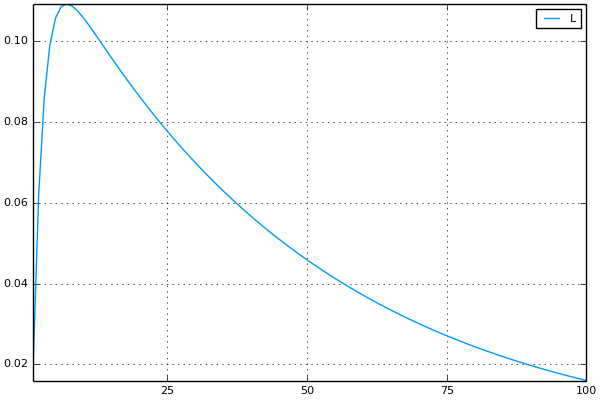

In [191]:
# L
plot(1:pds, policy[2,:]', label="L")


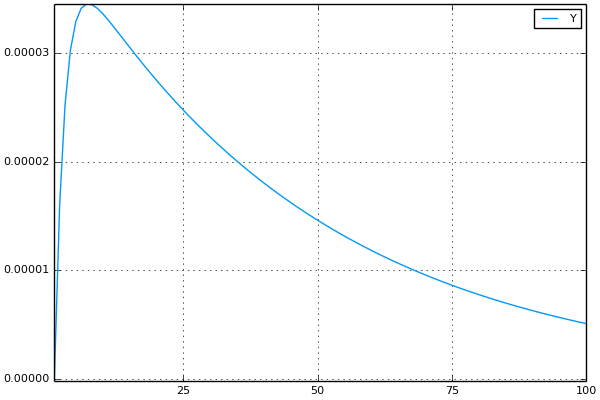

In [192]:
# Y
plot(1:pds, policy[3,:]', label="Y")


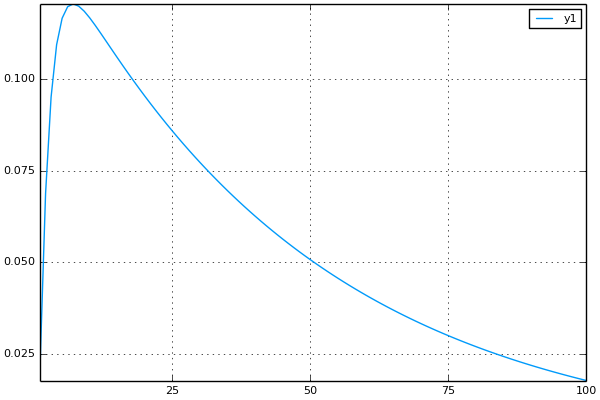

In [193]:
# R
plot(1:pds, policy[4,:]')

In [29]:
policy = "k"
state = "l"
lambda = Dict{AbstractString, Float64}();
lambda["$policy$state"]  = 5.0;

In [30]:
lambda

Dict{AbstractString,Float64} with 1 entry:
  "kl" => 5.0

In [17]:

size([1,2,3],1)

3

In [60]:

x = "k";
Float64(x == "k")

1.0